In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

from line_annotation import line_annotate

# OpenMP

## Scheduling strategies

In [2]:
N_EPOCHS = 1000
df = pd.read_csv('../benchmarks/results_scheduling_bak.csv')
df['n_organisms'] = df['grid_width'] * df['grid_height']
df["n_genes"] = df["n_organisms"] * df["genome_size"]
df['time_per_epoch'] = df['time'] / N_EPOCHS
df

,scheduling,n_threads,grid_width,grid_height,mutation_rate,genome_size,time,n_organisms,n_genes,time_per_epoch
0,guided,8,32,32,0.000100,500,153305,1024,512000,153.305
1,guided,8,32,32,0.000010,500,96006,1024,512000,96.006
2,guided,8,32,32,0.000001,500,98210,1024,512000,98.210
3,guided,8,128,128,0.000100,500,1890646,16384,8192000,1890.646
4,guided,8,128,128,0.000010,500,944511,16384,8192000,944.511
...,...,...,...,...,...,...,...,...,...,...
468,static,2,32,32,0.000010,50000,12578772,1024,51200000,12578.772
469,static,2,32,32,0.000001,50000,1931273,1024,51200000,1931.273
470,static,2,128,128,0.000100,50000,682487863,16384,819200000,682487.863
471,static,2,128,128,0.000010,50000,250413666,16384,819200000,250413.666


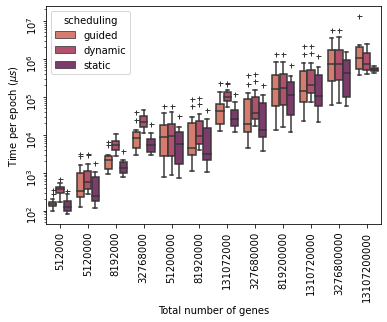

In [3]:
flierprops = dict(marker='+')
ax = sns.boxplot(data=df, x="n_genes", y="time_per_epoch", hue="scheduling", palette="flare", flierprops=flierprops)
ax.set(yscale="log")
ax.tick_params(labelrotation=90)
ax.set_xlabel("Total number of genes")
ax.set_ylabel("Time per epoch ($\mu s$)")
ax.get_figure().savefig('img/scheduling_strategies.pdf', bbox_inches="tight")

We investigate the static scheduling strategy as it performs better than the other ones.

In [4]:
df = pd.read_csv('../benchmarks/results_cpu_all_omp_static.csv')
df['n_organisms'] = df['grid_width'] * df['grid_height']
df['time_per_epoch'] = df['time'] / N_EPOCHS
df

,n_threads,grid_width,grid_height,mutation_rate,genome_size,time,n_organisms,time_per_epoch
0,8,32,32,0.000100,500,134295,1024,134.295
1,8,32,32,0.000010,500,103040,1024,103.040
2,8,32,32,0.000001,500,102114,1024,102.114
3,8,128,128,0.000100,500,1463354,16384,1463.354
4,8,128,128,0.000010,500,853253,16384,853.253
...,...,...,...,...,...,...,...,...
1315,6,32,32,0.000001,50000,855800,1024,855.800
1316,6,128,128,0.000100,50000,289391612,16384,289391.612
1317,6,128,128,0.000010,50000,68006495,16384,68006.495
1318,6,128,128,0.000001,50000,12384768,16384,12384.768


## Mean time per epoch

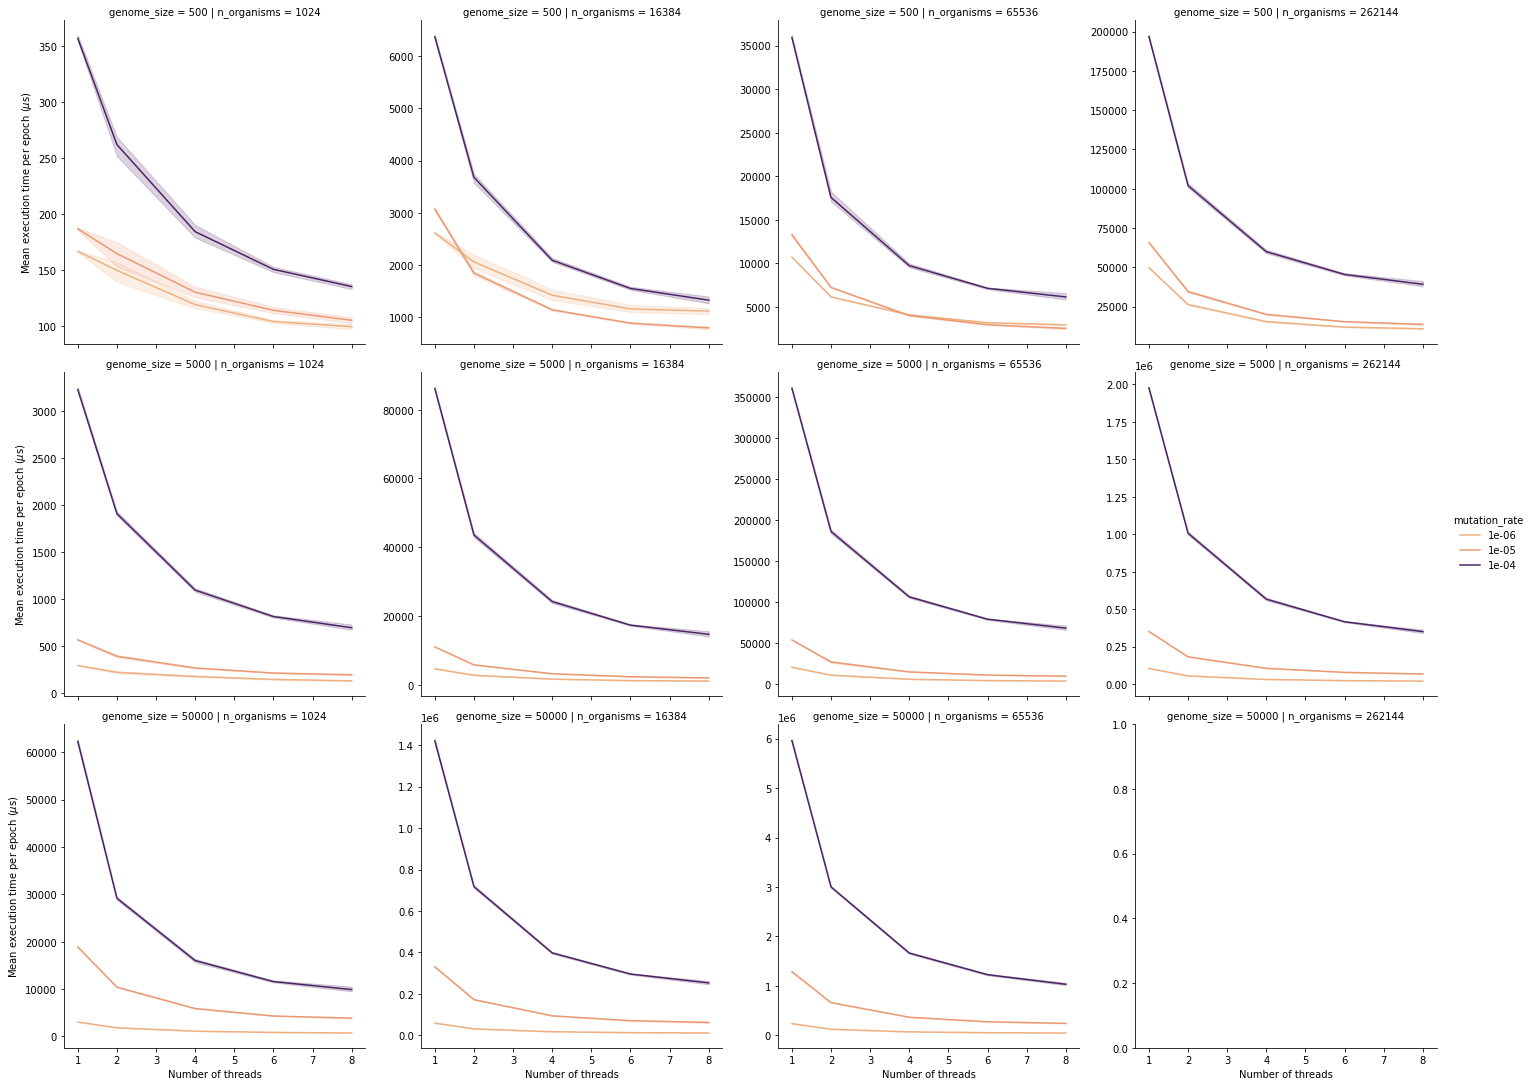

In [5]:
df_no_swp = df[(df['n_organisms'] != 512*512) | (df['genome_size'] != 50000)]
fig = sns.relplot(data=df_no_swp, x="n_threads", y="time_per_epoch", hue="mutation_rate", col="n_organisms", kind="line", row="genome_size", legend="full", facet_kws={'sharey': False}, palette='flare')
fig.set_xlabels("Number of threads")
fig.set_ylabels("Mean execution time per epoch ($\mu$s)")

# fix mix of scientific and decimal notation 
for legend in fig._legend.texts:
    legend.set_text( f'{float(legend.get_text()):.0e}')

plt.show(fig)
fig.savefig('img/benchmark_omp_static.pdf')

## Computing speedup

There definitely is a less stupid way of doing this

### Strong scaling

In [6]:
for n_organisms in df['n_organisms'].unique():
    for mutation_rate in df['mutation_rate'].unique():
        for genome_size in df['genome_size'].unique():
            baseline = df[(df['n_threads'] == 1) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size)]['time'].mean()
            for n_threads in df['n_threads'].unique():
                df.loc[(df['n_threads'] == n_threads) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size), 'strong_speedup'] = baseline / df[(df['n_threads'] == n_threads) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size)]['time']

In [7]:
from scipy import optimize

def amdahl(n, s):
    p = 1 - s
    return 1 / (s + p/n)

def gustafson(n, s):
    p = 1 - s
    return s + p * n

def fit_params(data, x_data_label, y_data_label, fixed_variable, law):
    results = []
    for value in data[fixed_variable].unique():
        subset = data[df[fixed_variable] == value]
        x_data = subset[x_data_label]
        y_data = subset[y_data_label]
        fitted = optimize.curve_fit(law, x_data, y_data)
        #print(f'popt : {fitted[0]} | pcov : {fitted[1]}')
        #sns.lineplot(x=x_data, y=law(x_data, *fitted[0]))
        results.append((x_data, fitted))
    return results

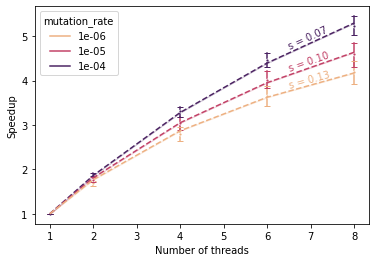

In [8]:
ax = sns.lineplot(data=df, x='n_threads', y='strong_speedup', hue='mutation_rate', marker=".",  
                  linestyle="", err_style='bars', palette="flare", hue_norm=mpl.colors.LogNorm(),
                  err_kws=dict(capsize=3))

# we need to save line colors to plot fitted functions with the same color
# get_lines return 9 objects because (I think) confidence intervals are just 
# transparent but still drawn on figure (3 data series * (1 median + 2 confidence intervals)
# we only want different colors so we use a set of all lines colors
# however ndarrays are not hashable so we map them to tuples to make them hashable
# sets are not indexable so we convert the resulting set to a list
# finally, we need to have an ordering we can find back to use the right color
# please kill me
colors = sorted(list(set(map(tuple, (l.get_c() for l in ax.get_lines())))))

amdahl_params = fit_params(df, "n_threads", "strong_speedup", "mutation_rate", amdahl)

# reverse sort and enumerate according to fitted parameters to find corresponding color 
# of color palette used for line 
for i, curve in enumerate(sorted(amdahl_params, key=lambda x:x[1][0][0], reverse=False)):
    x_data = curve[0]
    fitted_param, variance = curve[1]
    y_data = amdahl(x_data, fitted_param)
    ax = sns.lineplot(x=x_data, y=y_data, linestyle='--', color=colors[i], legend=None)
    line_annotate(f's = {fitted_param[0]:.2f}', ax.get_lines()[-1], 7, xytext=(0, 3), color=colors[i])
    
ax.set_xlabel("Number of threads")
ax.set_ylabel("Speedup")

# fix mix of scientific and decimal notation
for legend in ax.legend_.texts:
    legend.set_text(f'{float(legend.get_text()):.0e}')

ax.get_figure().savefig('img/speedup_mutation_rate.pdf', bbox_inches='tight')

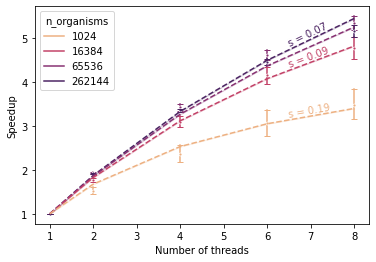

In [9]:
ax = sns.lineplot(data=df, x='n_threads', y='strong_speedup', hue='n_organisms', marker=".", 
                  linestyle="", err_style='bars', palette="flare", hue_norm=mpl.colors.LogNorm(),
                  err_kws=dict(capsize=3))
colors = sorted(list(set(map(tuple, (l.get_c() for l in ax.get_lines())))))

amdahl_params = fit_params(df, "n_threads", "strong_speedup", "n_organisms", amdahl)

for i, curve in enumerate(sorted(amdahl_params, key=lambda x:x[1][0][0], reverse=False)):
    x_data = curve[0]
    fitted_param, variance = curve[1]
    y_data = amdahl(x_data, fitted_param)
    ax = sns.lineplot(x=x_data, y=y_data, linestyle='--', color=colors[i], legend=None)
    if i != len(curve)-1:
        # last 2 curves have the same serial percentage and are too close to display both
        line_annotate(f's = {fitted_param[0]:.2f}', ax.get_lines()[-1], 7, xytext=(0, 3), color=colors[i])

ax.set_xlabel("Number of threads")
ax.set_ylabel("Speedup")

ax.get_figure().savefig('img/speedup_n_organisms.pdf', bbox_inches='tight')

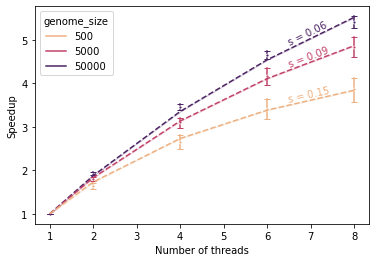

In [10]:
ax = sns.lineplot(data=df, x='n_threads', y='strong_speedup', hue='genome_size', marker=".", 
                  linestyle="", err_style='bars', palette="flare", hue_norm=mpl.colors.LogNorm(),
                  err_kws=dict(capsize=3))
colors = sorted(list(set(map(tuple, (l.get_c() for l in ax.get_lines())))))

amdahl_params = fit_params(df, "n_threads", "strong_speedup", "genome_size", amdahl)

for i, curve in enumerate(sorted(amdahl_params, key=lambda x:x[1][0][0], reverse=False)):
    x_data = curve[0]
    fitted_param, variance = curve[1]
    y_data = amdahl(x_data, fitted_param)
    ax = sns.lineplot(x=x_data, y=y_data, linestyle='--', color=colors[i], legend=None)
    line_annotate(f's = {fitted_param[0]:.2f}', ax.get_lines()[-1], 7, xytext=(0, 3), color=colors[i])
    
    
ax.set_xlabel("Number of threads")
ax.set_ylabel("Speedup")

ax.get_figure().savefig('img/speedup_genome_size.pdf', bbox_inches='tight')

### Weak scaling

In [11]:
df = pd.read_csv('../benchmarks/results_cpu_weak_scaling.csv')
df["n_organisms"] = df["grid_height"] * df["grid_width"]
df["time_per_epoch"] = df["time"] / N_EPOCHS

for mutation_rate in df["mutation_rate"].unique():
    for genome_size in df["genome_size"].unique():
        baseline = df[(df["n_threads"] == 1) & (df["genome_size"] == genome_size) & (df["mutation_rate"] == mutation_rate)]["time_per_epoch"].mean()
        time_p = df[(df["genome_size"] == genome_size) & (df["mutation_rate"] == mutation_rate)]["time_per_epoch"]
        n_threads = df[(df["genome_size"] == genome_size) & (df["mutation_rate"] == mutation_rate)]["n_threads"]
        df.loc[(df["genome_size"] == genome_size) & (df["mutation_rate"] == mutation_rate), "weak_speedup"] = (n_threads * baseline) / time_p

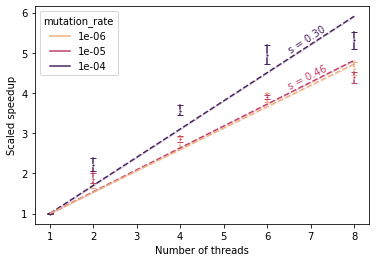

In [12]:
ax = sns.lineplot(data=df, x='n_threads', y='weak_speedup', hue='mutation_rate', marker=".", 
                  linestyle="", err_style='bars', palette="flare", hue_norm=mpl.colors.LogNorm(),
                  err_kws=dict(capsize=3))

# tweak sorting to map to the right data points (this is horrible) 
colors = sorted(list(set(map(tuple, (l.get_c() for l in ax.get_lines())))), key=lambda x:x[1])

gustafson_params = fit_params(df, "n_threads", "weak_speedup", "mutation_rate", gustafson)

for i, curve in enumerate(sorted(gustafson_params, key=lambda x:x[1][0][0], reverse=False)):
    x_data = curve[0]
    fitted_param, variance = curve[1]
    y_data = gustafson(x_data, fitted_param)
    ax = sns.lineplot(x=x_data, y=y_data, linestyle='--', color=colors[i], legend=None)
    if i != 2: 
        line_annotate(f's = {fitted_param[0]:.2f}', ax.get_lines()[-1], 7, xytext=(0, 3), color=colors[i])

# fix mix of scientific and decimal notation
for legend in ax.legend_.texts:
    legend.set_text(f'{float(legend.get_text()):.0e}')
    
ax.set_xlabel("Number of threads")
ax.set_ylabel("Scaled speedup")

ax.get_figure().savefig('img/weak_speedup_mutation_rate.pdf', bbox_inches='tight')

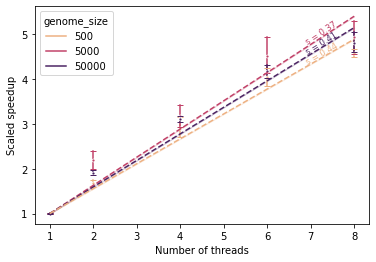

In [13]:
ax = sns.lineplot(data=df, x='n_threads', y='weak_speedup', hue='genome_size', marker=".", 
                  linestyle="", err_style='bars', palette="flare", hue_norm=mpl.colors.LogNorm(),
                  err_kws=dict(capsize=3))

# exchange after sort to get the right mapping (even more horrible)
colors = sorted(list(set(map(tuple, (l.get_c() for l in ax.get_lines())))))
colors[0], colors[1] = colors[1], colors[0]

gustafson_params = fit_params(df, "n_threads", "weak_speedup", "genome_size", gustafson)

for i, curve in enumerate(sorted(gustafson_params, key=lambda x:x[1][0][0], reverse=False)):
    x_data = curve[0]
    fitted_param, variance = curve[1]
    y_data = gustafson(x_data, fitted_param)
    ax = sns.lineplot(x=x_data, y=y_data, linestyle='--', color=colors[i], legend=None)
    h_offset = 0.3
    line_annotate(f's = {fitted_param[0]:.2f}', ax.get_lines()[-1], 7+h_offset, xytext=(0, 1), color=colors[i], fontproperties={'size':'small'})

    
ax.set_xlabel("Number of threads")
ax.set_ylabel("Scaled speedup")

ax.get_figure().savefig('img/weak_speedup_genome_size.pdf', bbox_inches='tight')

## Pointer-swap vs loop-swap

In [14]:
df = pd.read_csv('../benchmarks/swap_strategies.csv')
df['n_organisms'] = df['grid_width'] * df['grid_height']
df["n_genes"] = df["n_organisms"] * df["genome_size"]
df['time_per_epoch'] = df['time'] / N_EPOCHS
df

,method,n_threads,grid_height,grid_width,mutation_rate,genome_size,time,n_organisms,n_genes,time_per_epoch
0,for_swap,8,32,32,0.000100,500,140447,1024,512000,140.447
1,for_swap,8,32,32,0.000010,500,303373,1024,512000,303.373
2,for_swap,8,32,32,0.000001,500,79613,1024,512000,79.613
3,for_swap,8,128,128,0.000100,500,1837381,16384,8192000,1837.381
4,for_swap,8,128,128,0.000010,500,1035636,16384,8192000,1035.636
...,...,...,...,...,...,...,...,...,...,...
1060,pointer_swap,1,128,128,0.000010,5000,12807512,16384,81920000,12807.512
1061,pointer_swap,1,128,128,0.000001,5000,5252776,16384,81920000,5252.776
1062,pointer_swap,1,256,256,0.000100,5000,383391610,65536,327680000,383391.610
1063,pointer_swap,1,256,256,0.000010,5000,62920853,65536,327680000,62920.853


In [15]:
for n_organisms in df['n_organisms'].unique():
    for mutation_rate in df['mutation_rate'].unique():
        for genome_size in df['genome_size'].unique():
            for n_threads in df['n_threads'].unique():
                pointer_swap_time = df[(df['method'] == 'pointer_swap') & (df['n_threads'] == n_threads) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size)]['time'].mean()
                for_swap_time = df[(df['method'] == 'for_swap') & (df['n_threads'] == n_threads) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size)]['time'].mean()
                if pointer_swap_time > 1 and for_swap_time > 1:
                    df.loc[(df['method'] == 'pointer_swap') & (df['n_threads'] == n_threads) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size), 'time_gain'] = for_swap_time - pointer_swap_time

df["time_gain"].describe()

count    4.860000e+02
mean    -1.749191e+07
std      7.275299e+07
min     -9.173969e+08
25%     -5.155222e+06
50%     -7.770000e+02
75%      1.446180e+05
max      8.780549e+07
Name: time_gain, dtype: float64

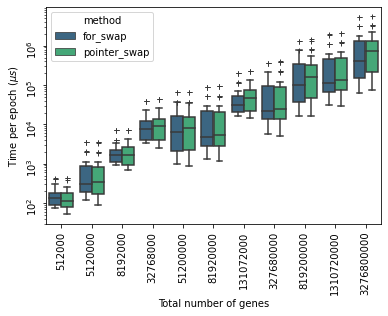

In [16]:
flierprops = dict(marker='+')
ax = sns.boxplot(data=df, x="n_genes", y="time_per_epoch", hue="method", palette="viridis", flierprops=flierprops)
ax.set(yscale="log")
ax.tick_params(labelrotation=90)
ax.set_xlabel("Total number of genes")
ax.set_ylabel("Time per epoch ($\mu s$)")
ax.get_figure().savefig('img/swap_strategies.pdf', bbox_inches="tight")

# CUDA

In [17]:
N_ITERATIONS = 500
df = pd.read_csv('../benchmarks/kernel_timings_full.csv')

# do not show kernel called only once and memory transfers
df = df.groupby(by='Name').filter(lambda x: len(x) == N_ITERATIONS or len(x) == N_ITERATIONS+1)

df.sort_values(['Duration(ns)'], ascending=False, inplace=True)

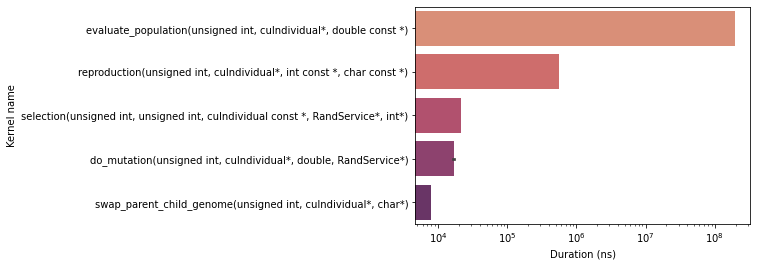

In [18]:
ax = sns.barplot(data=df, x="Duration(ns)", y="Name", palette='flare')
ax.set(xscale="log")

ax.set_xlabel("Duration (ns)")
ax.set_ylabel("Kernel name")

ax.get_figure().savefig('img/kernel_timings.pdf', bbox_inches='tight')

# Compression

Using data from [lzbench](https://github.com/inikep/lzbench)

In [19]:
df = pd.read_csv("../benchmarks/compression.csv")
df = df[df["name"].str.contains("zlib|lz4|zstd")]
df.sort_values("compression_speed", ascending=False)

,name,options,compression_speed,decompression_speed,compression_size,compression_ratio
180,lz4fast 1.9.2,-17.0,1201.00,4632,131732802.0,62.15
174,lz4fast 1.9.2,-3.0,838.00,4423,107066190.0,50.52
157,lz4 1.9.2,NaN,737.00,4448,100880800.0,47.60
75,zstd 1.4.3,-1.0,480.00,1203,73508823.0,34.68
62,zstd 1.4.3,-2.0,356.00,1067,69594511.0,32.84
152,slz_zlib 1.0.0,-1.0,301.00,380,99657958.0,47.02
146,slz_zlib 1.0.0,-2.0,297.00,378,96863094.0,45.70
144,slz_zlib 1.0.0,-3.0,293.00,379,96187780.0,45.38
116,lz4hc 1.9.2,-1.0,131.00,4071,83803769.0,39.54
95,zlib 1.2.11,-1.0,119.00,383,77259029.0,36.45


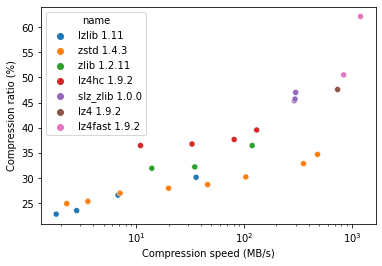

In [20]:
ax = sns.scatterplot(data=df, x="compression_speed", y="compression_ratio", hue="name")
ax.set_xlabel("Compression speed (MB/s)")
ax.set_ylabel("Compression ratio (%)")
ax.set(xscale="log")

ax.get_figure().savefig("img/compression_tools.pdf", bbox_inches='tight')